In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import boto3
import os.path as op
import nibabel as nib
%matplotlib inline

In [2]:
subjects = [int(s) for s in np.loadtxt('./hcp900.txt')]

In [3]:
boto3.setup_default_session(profile_name='escience')
s3 = boto3.resource('s3')
bucket = s3.Bucket('arokem-hcp-dki')

In [4]:
import tempfile
tempfile.TemporaryDirectory()

<TemporaryDirectory '/var/folders/56/4s8_k8_s2n9c1622_bmnz7m40000gn/T/tmpeyedlyy1'>

In [5]:
tempfile.tempdir

'/var/folders/56/4s8_k8_s2n9c1622_bmnz7m40000gn/T'

In [6]:
import pandas as pd
import seaborn as sns

In [7]:
fname = 'cod_medians.csv'
if not op.exists(fname):
    dki_medians = []
    dti_medians = []
    cod_dki_file = op.join(tempfile.tempdir, 'cod_dki.nii.gz')
    cod_dti_file = op.join(tempfile.tempdir, 'cod_dti.nii.gz')
    wm_file = op.join(tempfile.tempdir, 'wm_mask.nii.gz')
    for subject in subjects:
        try:
            path_dki = '%s/%s_cod_dki.nii.gz' % (subject, subject)
            path_dti = '%s/%s_cod_dti.nii.gz' % (subject, subject)
            path_wm = '%s/%s_white_matter_mask.nii.gz' % (subject, subject)
            bucket.download_file(path_dki, cod_dki_file)
            bucket.download_file(path_dti, cod_dti_file)
            bucket.download_file(path_wm, wm_file)
            mask = nib.load(wm_file).get_data().astype(bool)
            cod_dki = nib.load(cod_dki_file).get_data()[mask]
            cod_dti = nib.load(cod_dti_file).get_data()[mask]
            median_dki = np.nanmedian(cod_dki)
            median_dti = np.nanmedian(cod_dti)
            dki_medians.append(median_dki)
            dti_medians.append(median_dti)
            print("Subject %s works fine!" % subject)
        except Exception as err:
            print("Subject %s seems to have issues" % subject)
            print(err.args)

    df = pd.DataFrame(np.array([dti_medians, dki_medians]).T, columns=["DTI", "DKI"])
else:
    df = pd.read_csv('cod_medians.csv')
    dti_medians = df["DTI"]
    dki_medians = df["DKI"]

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 32.99999999999995, '$R^2$ (DKI)')

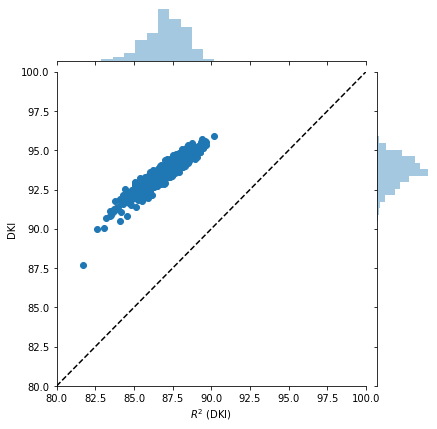

In [10]:
ax = sns.jointplot(data=df, x='DTI', y="DKI", marker='o')
ax.ax_joint.plot([80, 100], [80, 100], 'k--')
ax.ax_joint.set_xlim([80, 100])
ax.ax_joint.set_ylim([80, 100])
ax.ax_joint.set_xlabel('$R^2$ (DTI)')
ax.ax_joint.set_xlabel('$R^2$ (DKI)')

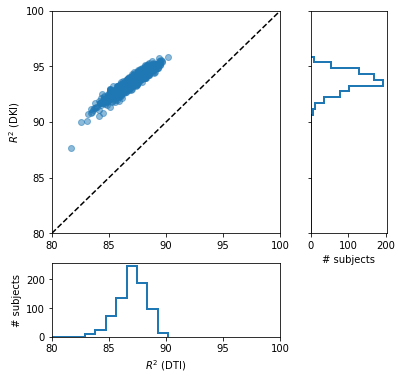

In [11]:
fig, ax = plt.subplots()
gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1])
ax = plt.subplot(gs[0,0])
axx = plt.subplot(gs[1,0], sharex=ax)
axy = plt.subplot(gs[0,1])
ax.plot(dti_medians, dki_medians, 'o', alpha=0.5)
axx.hist(dti_medians, bins=40, histtype='step', linewidth=2)
axy.hist(dki_medians, bins=40, histtype='step', linewidth=2, orientation='horizontal')
ax.plot([80, 100], [80, 100], 'k--')
ax.set_ylabel('$R^2$ (DKI)')
axx.set_xlabel('$R^2$ (DTI)')
axx.set_ylabel('# subjects')
axy.set_xlabel('# subjects')
ax.set_yticks([80, 85, 90, 95, 100])
ax.set_yticklabels([80, 85, 90, 95, 100])
axy.set_yticklabels('')
ax.set_xlim([80, 100])
ax.set_ylim([80, 100])
axy.set_ylim([80, 100])
axy.set_yticks([80, 85, 90, 95, 100])
axy.set_xticks([0, 100, 200])

fig.set_size_inches([6, 6])
fig.savefig('cod_dki_dti.png')

In [12]:
len(dti_medians)

789

In [13]:
dti_arr = np.array(dti_medians)
dki_arr = np.array(dki_medians)

In [14]:
np.argmin(dti_arr)

19